In [1]:

from utils.dataset import  CustomDataset
import os
import warnings
warnings.filterwarnings("ignore")
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sys
import pandas as pd
from tqdm import tqdm
import threading
import random
# import rasterio
import os
import numpy as np
import sys
from sklearn.utils import shuffle as shuffle_lists
import numpy as np
from sklearn.model_selection import train_test_split
import joblib

import torch

#default
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

#trasnform
from torchvision import transforms

#dataset
from utils.dataset import CustomDataset
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler

#metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import torchmetrics.functional as tf

#numeric
import numpy as np
import pandas as pd 

#visualization
import matplotlib.pyplot as plt

#system 
from tqdm import tqdm
import os 
import wandb
import datetime


In [2]:
now = datetime.datetime.now()
formatted_now = now.strftime("%Y%m%d%H%M")
checkpoint_datetime = formatted_now
print(f"#"*30, "SAVE TIME", "#"*30)
print(f"#"*30, checkpoint_datetime, "#"*30)

############################## SAVE TIME ##############################
############################## 202403211104 ##############################


In [3]:
train_csv = '../../dataset/train_meta.csv'

train_transform = transforms.Compose([
    # transforms.Resize((512,512), antialias= True),
    # transforms.RandomApply([
    #     transforms.RandomRotation(degrees = 30),
    #     transforms.RandomVerticalFlip(p= 0.5),
    #     transforms.RandomVerticalFlip(p=0.5),
    #     transforms.RandomCrop(size =224, scale= (0.8, 1.2), ratio = (0.75, 1.2), antialias = True),
    #     transforms.ColorJitter(brightness= 0.2, contrast = 0.2)
    # ]),
    transforms.ToTensor()
])
tr_batch = 64
vl_batch = 8

dataset = CustomDataset(
    csv_path= train_csv,
    transform= None, #None으로 세팅
    MAX_PIXEL_VALUE= 65535,
    band = (7,6,2) #기존 세팅 
)

# 훈련 및 검증 세트 분할
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size 
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = tr_batch
    # sampler= ImbalancedDatasetSampler(train_dataset),
)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle= False)



torch.Size([64, 256, 256, 3])


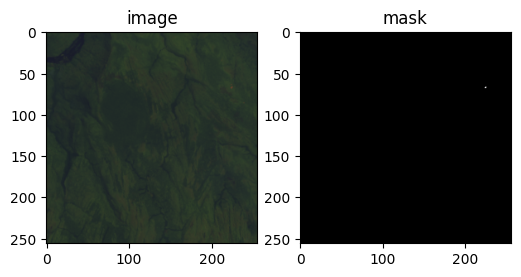

torch.Size([8, 256, 256, 3])


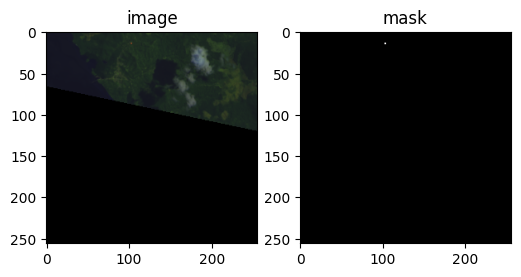

In [4]:
for images, masks in train_loader:
    print(images.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx], cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

for images, masks in valid_loader:
    print(images.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx], cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

In [5]:
#model
sys.path.append('../')
from network.models import get_pretrained_model

# if torch.cuda.is_available():
#     device = 'cuda'
#     torch.cuda.manual_seed_all(42)
device = 'cuda'
# # random seed 고정
# random.seed(42)
# if torch.cuda.is_available():
#     device = torch.device('cuda')
#     torch.cuda.manual_seed_all(42)
# else:
#     device = torch.device('cuda')
#     torch.manual_seed_all(42)

# # model & cost func & optimizer 정의
############################ V1~2 #############################
"""model = get_pretrained_model('unet').get()"""
############################ V3~4 #############################
# model = AttU_Net(img_ch= 3, output_ch= 1)
# model = get_pretrained_model('attunet').get()
# model = get_pretrained_model('r2attunet').get()
############################ V5 #############################
# model = get_pretrained_model('unet++').get()
############################ V6 #############################
model = get_pretrained_model('manet').get()

model.to(device)

lr = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda= lambda epoch: 0.95**epoch)

loss = nn.BCELoss()

print(f'device : {device}')
# summary(model, input_size=(3, 224, 224))



Model name : manet
device : cuda


In [6]:
metrics = {
    'tr_bce' : [],
    'vl_bce' : [],
    'tr_iou' : [],
    'vl_iou' : [],
}
epoch, epochs = 0, 200
early_stopping_epochs, early_stopping_cnt= 10, 0
SAVE_DIR = '../../satellite_model'
best_loss = float('inf')


In [7]:
def checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds):
    # loss plot
    plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.plot(metrics['tr_bce'], label='Train Loss')
    plt.plot(metrics['vl_bce'], label='Valid Loss')
    plt.title("BCE | DOWN GOOD")
    plt.legend()
    plt.subplot(122)
    plt.plot(metrics['tr_iou'], label='Train IoU')
    plt.plot(metrics['vl_iou'], label='Valid IoU')
    plt.title("mIOU | UP GOOD")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_loss.png'))
    plt.close()
    
    # mask plot
    plt.figure(figsize=(10, 7))
    plt.subplot(131)
    plt.imshow(images[0].cpu().permute(1,2,0))
    plt.title('image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(masks[0].cpu().permute(1,2,0))
    plt.title('mask')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(preds[0].cpu().permute(1,2,0))
    plt.title('pred')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_mask.png'))
    plt.close()
    
    torch.save({
        "model" : f"{epoch}",
        "epoch" : epoch,
        "epochs" : epochs,
        "model_state_dict" : model.state_dict(),
        "optimizer_state_dict" : optimizer.state_dict(),
        "learning_rate" : lr,
        "loss" : loss,
        "metric" : metrics,
        "description" : f"segmentation model training status : {epoch}/{epochs}"
    },
    os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}.pt'))
    print(f"#"*30, f"SAVE PATH : {SAVE_DIR}", "#"*30)
    
def calculate_iou(preds, masks, threshold=0.5):
    # 예측 마스크를 이진 형태로 변환
    preds = (preds > threshold).float()
    
    intersection = torch.sum(preds * masks)
    union = torch.sum((preds + masks) > 0)
    
    iou = (intersection + 1e-7) / (union + 1e-7)  # 0으로 나누는 경우를 방지하기 위해 작은 값(1e-7)을 추가
    
    return iou

In [8]:
for epoch in tqdm(range(epoch, epochs), desc="Training Progress"):
    train_losses, valid_losses = 0., 0.
    train_ious, valid_ious = 0., 0.
    
    model.train()
    for _, (images, masks) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images, masks = images.to(device), masks.to(device)
        images = images.permute(0,3,1,2)
        masks = masks.permute(0,3,1,2)
        
        preds = model(images)
        train_loss = loss(preds, masks).to(device)
        train_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses += train_loss.item()
        train_ious += train_iou
        break 
    scheduler.step()
    
    metrics['tr_bce'].append(train_losses / len(train_loader))
    metrics['tr_iou'].append(train_ious / len(train_loader))
    print(f"Epoch : {epoch}/{epochs} | Train Loss : {train_losses / len(train_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Train IOU : {train_ious / len(train_loader)}")
    
    with torch.no_grad():
        model.eval()
        for _, (images, masks) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            images, masks = images.to(device), masks.to(device)
            images = images.permute(0,3,1,2)
            masks = masks.permute(0,3,1,2)

            preds = model(images)
            valid_loss = loss(preds, masks).to(device)
            valid_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
            valid_losses += valid_loss.item()
            valid_ious += valid_iou
            break
            

    metrics['vl_bce'].append(valid_losses / len(valid_loader))
    metrics['vl_iou'].append(valid_ious / len(valid_loader))
    print(f"Epoch : {epoch}/{epochs} | Valid Loss : {valid_losses / len(valid_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Valid IOU : {valid_ious / len(valid_loader)}")

    # Early Stopping
    if valid_losses > best_loss:
        best_loss = valid_losses
        early_stopping_cnt = 0
    else:
        early_stopping_cnt += 1
        if early_stopping_cnt >= early_stopping_epochs:
            print(f"Early Stops!!! : {epoch}/{epochs}")
            # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    
    # Validation 성능이 이전보다 우수한 경우 모델 저장
    try:        
        if valid_losses > np.array(metrics['vl_bce'])[:-1].max() and epoch%10 == 0:
            pass
            # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    except Exception as e:
        print(e)
        pass

Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 0/200 | Train Loss : 0.0021690443867728826
Epoch : 0/200 | Train IOU : 6.769273091950232e-07


Training Progress:   0%|          | 1/200 [00:01<03:31,  1.06s/it]

Epoch : 0/200 | Valid Loss : 0.0009697576363881429
Epoch : 0/200 | Valid IOU : 1.3444807250163563e-07
zero-size array to reduction operation maximum which has no identity


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 1/200 | Train Loss : 0.0019867401747476485
Epoch : 1/200 | Train IOU : 7.055859896354377e-07


Training Progress:   1%|          | 2/200 [00:01<03:10,  1.04it/s]

Epoch : 1/200 | Valid Loss : 0.0009796148254757836
Epoch : 1/200 | Valid IOU : 1.335419905704579e-07


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 2/200 | Train Loss : 0.0018887864691870552
Epoch : 2/200 | Train IOU : 7.224657955313368e-07


Training Progress:   2%|▏         | 3/200 [00:02<02:54,  1.13it/s]

Epoch : 2/200 | Valid Loss : 0.0009609223831267584
Epoch : 2/200 | Valid IOU : 1.2547912081659195e-07


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 3/200 | Train Loss : 0.001822449905531747
Epoch : 3/200 | Train IOU : 7.491412578106281e-07


Training Progress:   2%|▏         | 4/200 [00:03<02:41,  1.22it/s]

Epoch : 3/200 | Valid Loss : 0.000937703890459878
Epoch : 3/200 | Valid IOU : 1.2805230653611943e-07


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 4/200 | Train Loss : 0.0017592790580931163
Epoch : 4/200 | Train IOU : 7.538103437539013e-07


Training Progress:   2%|▎         | 5/200 [00:04<02:41,  1.21it/s]

Epoch : 4/200 | Valid Loss : 0.000906382855914888
Epoch : 4/200 | Valid IOU : 1.365604475722648e-07


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 5/200 | Train Loss : 0.0017167529889515467
Epoch : 5/200 | Train IOU : 8.14232459690954e-07


Training Progress:   3%|▎         | 6/200 [00:05<02:35,  1.25it/s]

Epoch : 5/200 | Valid Loss : 0.0008663510992413476
Epoch : 5/200 | Valid IOU : 1.3775797491516208e-07


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 6/200 | Train Loss : 0.001677580958320981
Epoch : 6/200 | Train IOU : 8.369350412283979e-07


Training Progress:   4%|▎         | 7/200 [00:05<02:26,  1.32it/s]

Epoch : 6/200 | Valid Loss : 0.0008342661318324861
Epoch : 6/200 | Valid IOU : 1.3302096271044796e-07


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 7/200 | Train Loss : 0.0016434216783160255
Epoch : 7/200 | Train IOU : 8.642689430243557e-07


Training Progress:   4%|▍         | 8/200 [00:06<02:30,  1.28it/s]

Epoch : 7/200 | Valid Loss : 0.0008080647814841498
Epoch : 7/200 | Valid IOU : 1.410600383505447e-07


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 8/200 | Train Loss : 0.0016183945394697644
Epoch : 8/200 | Train IOU : 8.814563486902486e-07


Training Progress:   4%|▍         | 9/200 [00:07<02:27,  1.29it/s]

Epoch : 8/200 | Valid Loss : 0.0007885761913799104
Epoch : 8/200 | Valid IOU : 1.7160993939753446e-07


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 9/200 | Train Loss : 0.0015921323072342645
Epoch : 9/200 | Train IOU : 9.187772299074346e-07


Training Progress:   5%|▌         | 10/200 [00:07<02:21,  1.34it/s]

Epoch : 9/200 | Valid Loss : 0.0007748917454764956
Epoch : 9/200 | Valid IOU : 2.081443588914616e-07
Early Stops!!! : 9/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 10/200 | Train Loss : 0.0015722337223234631
Epoch : 10/200 | Train IOU : 9.409291946905709e-07


Training Progress:   6%|▌         | 11/200 [00:08<02:26,  1.29it/s]

Epoch : 10/200 | Valid Loss : 0.0007649758741969154
Epoch : 10/200 | Valid IOU : 2.3791241498353581e-07
Early Stops!!! : 10/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 11/200 | Train Loss : 0.0015508949756622315
Epoch : 11/200 | Train IOU : 9.934870398692076e-07


Training Progress:   6%|▌         | 12/200 [00:09<02:19,  1.35it/s]

Epoch : 11/200 | Valid Loss : 0.0007568451620283581
Epoch : 11/200 | Valid IOU : 2.2098287272023127e-07
Early Stops!!! : 11/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 12/200 | Train Loss : 0.0015362427348182316
Epoch : 12/200 | Train IOU : 1.033609441947192e-06


Training Progress:   6%|▋         | 13/200 [00:10<02:14,  1.39it/s]

Epoch : 12/200 | Valid Loss : 0.0007497451135090419
Epoch : 12/200 | Valid IOU : 2.267026762378269e-07
Early Stops!!! : 12/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 13/200 | Train Loss : 0.0015219034183593023
Epoch : 13/200 | Train IOU : 1.0805399229173505e-06


Training Progress:   7%|▋         | 14/200 [00:10<02:10,  1.42it/s]

Epoch : 13/200 | Valid Loss : 0.0007437293018613543
Epoch : 13/200 | Valid IOU : 2.0899367102954003e-07
Early Stops!!! : 13/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 14/200 | Train Loss : 0.0015093211616788592
Epoch : 14/200 | Train IOU : 1.1532794035572026e-06


Training Progress:   8%|▊         | 15/200 [00:11<02:08,  1.44it/s]

Epoch : 14/200 | Valid Loss : 0.0007374306519826253
Epoch : 14/200 | Valid IOU : 1.8818782769986206e-07
Early Stops!!! : 14/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 15/200 | Train Loss : 0.00149748580796378
Epoch : 15/200 | Train IOU : 1.1965187565822686e-06


Training Progress:   8%|▊         | 16/200 [00:12<02:06,  1.46it/s]

Epoch : 15/200 | Valid Loss : 0.0007316576583044869
Epoch : 15/200 | Valid IOU : 2.3408694167821004e-07
Early Stops!!! : 15/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 16/200 | Train Loss : 0.0014863923901603335
Epoch : 16/200 | Train IOU : 1.197738068488737e-06


Training Progress:   8%|▊         | 17/200 [00:12<02:04,  1.47it/s]

Epoch : 16/200 | Valid Loss : 0.0007259266717093331
Epoch : 16/200 | Valid IOU : 1.5079578068772597e-07
Early Stops!!! : 16/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 17/200 | Train Loss : 0.0014764663718995594
Epoch : 17/200 | Train IOU : 1.2243646086149273e-06


Training Progress:   9%|▉         | 18/200 [00:13<02:03,  1.48it/s]

Epoch : 17/200 | Valid Loss : 0.0007203715188162668
Epoch : 17/200 | Valid IOU : 2.168875826533795e-07
Early Stops!!! : 17/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 18/200 | Train Loss : 0.0014674328622363863
Epoch : 18/200 | Train IOU : 1.261758595882427e-06


Training Progress:  10%|▉         | 19/200 [00:14<02:01,  1.48it/s]

Epoch : 18/200 | Valid Loss : 0.0007150421539942423
Epoch : 18/200 | Valid IOU : 2.2545732679732497e-07
Early Stops!!! : 18/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 19/200 | Train Loss : 0.0014622533605212257
Epoch : 19/200 | Train IOU : 1.2446642531791614e-06


Training Progress:  10%|█         | 20/200 [00:14<02:00,  1.49it/s]

Epoch : 19/200 | Valid Loss : 0.0007088214868590945
Epoch : 19/200 | Valid IOU : 2.5877573837836585e-07
Early Stops!!! : 19/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 20/200 | Train Loss : 0.0014575342337290445
Epoch : 20/200 | Train IOU : 1.2276245148054192e-06


Training Progress:  10%|█         | 21/200 [00:15<02:00,  1.49it/s]

Epoch : 20/200 | Valid Loss : 0.0007031237795239403
Epoch : 20/200 | Valid IOU : 2.9321516714324907e-07
Early Stops!!! : 20/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 21/200 | Train Loss : 0.0014517764250437418
Epoch : 21/200 | Train IOU : 1.242503501652252e-06


Training Progress:  11%|█         | 22/200 [00:16<01:59,  1.49it/s]

Epoch : 21/200 | Valid Loss : 0.0006975962292580378
Epoch : 21/200 | Valid IOU : 3.8910435423964545e-07
Early Stops!!! : 21/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 22/200 | Train Loss : 0.0014456547441936674
Epoch : 22/200 | Train IOU : 1.2717169565370396e-06


Training Progress:  12%|█▏        | 23/200 [00:16<01:58,  1.50it/s]

Epoch : 22/200 | Valid Loss : 0.0006936619679133098
Epoch : 22/200 | Valid IOU : 2.810654612923307e-07
Early Stops!!! : 22/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 23/200 | Train Loss : 0.0014389827137901668
Epoch : 23/200 | Train IOU : 1.2858391052023286e-06


Training Progress:  12%|█▏        | 24/200 [00:17<01:57,  1.49it/s]

Epoch : 23/200 | Valid Loss : 0.0006903183602151417
Epoch : 23/200 | Valid IOU : 3.2804524553717955e-07
Early Stops!!! : 23/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 24/200 | Train Loss : 0.001431846334820702
Epoch : 24/200 | Train IOU : 1.301565429284459e-06


Training Progress:  12%|█▎        | 25/200 [00:18<01:56,  1.50it/s]

Epoch : 24/200 | Valid Loss : 0.0006871854975110008
Epoch : 24/200 | Valid IOU : 4.3707460420028794e-07
Early Stops!!! : 24/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 25/200 | Train Loss : 0.0014254879383813767
Epoch : 25/200 | Train IOU : 1.3430209253870306e-06


Training Progress:  13%|█▎        | 26/200 [00:18<01:56,  1.50it/s]

Epoch : 25/200 | Valid Loss : 0.0006845763751438686
Epoch : 25/200 | Valid IOU : 4.4992391069951866e-07
Early Stops!!! : 25/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 26/200 | Train Loss : 0.0014189744279498146
Epoch : 26/200 | Train IOU : 1.3873437031482658e-06


Training Progress:  14%|█▎        | 27/200 [00:19<01:55,  1.50it/s]

Epoch : 26/200 | Valid Loss : 0.0006815835123970395
Epoch : 26/200 | Valid IOU : 5.016083291376986e-07
Early Stops!!! : 26/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 27/200 | Train Loss : 0.0014129699695677985
Epoch : 27/200 | Train IOU : 1.3971054050627918e-06


Training Progress:  14%|█▍        | 28/200 [00:20<01:55,  1.49it/s]

Epoch : 27/200 | Valid Loss : 0.0006803790728251139
Epoch : 27/200 | Valid IOU : 3.969871267188518e-07
Early Stops!!! : 27/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 28/200 | Train Loss : 0.001408044213340396
Epoch : 28/200 | Train IOU : 1.4399379281149734e-06


Training Progress:  14%|█▍        | 29/200 [00:20<01:54,  1.49it/s]

Epoch : 28/200 | Valid Loss : 0.0006797327172188532
Epoch : 28/200 | Valid IOU : 2.766520213169445e-07
Early Stops!!! : 28/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 29/200 | Train Loss : 0.0014027147066025508
Epoch : 29/200 | Train IOU : 1.4899186291066663e-06


Training Progress:  15%|█▌        | 30/200 [00:21<01:53,  1.49it/s]

Epoch : 29/200 | Valid Loss : 0.0006797901221684047
Epoch : 29/200 | Valid IOU : 3.462699948743518e-07
Early Stops!!! : 29/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 30/200 | Train Loss : 0.0013973982561202277
Epoch : 30/200 | Train IOU : 1.5622162858822517e-06


Training Progress:  16%|█▌        | 31/200 [00:22<01:53,  1.50it/s]

Epoch : 30/200 | Valid Loss : 0.0006798197116170611
Epoch : 30/200 | Valid IOU : 3.8709636317521687e-07
Early Stops!!! : 30/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 31/200 | Train Loss : 0.001392535368601481
Epoch : 31/200 | Train IOU : 1.6009498808887742e-06


Training Progress:  16%|█▌        | 32/200 [00:22<01:52,  1.50it/s]

Epoch : 31/200 | Valid Loss : 0.0006800819010961623
Epoch : 31/200 | Valid IOU : 3.3399687492332996e-07
Early Stops!!! : 31/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 32/200 | Train Loss : 0.0013876405500230335
Epoch : 32/200 | Train IOU : 1.628637324929947e-06


Training Progress:  16%|█▋        | 33/200 [00:23<01:51,  1.49it/s]

Epoch : 32/200 | Valid Loss : 0.0006812951394489833
Epoch : 32/200 | Valid IOU : 3.014582034666091e-07
Early Stops!!! : 32/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 33/200 | Train Loss : 0.001382792563665481
Epoch : 33/200 | Train IOU : 1.6644440447202042e-06


Training Progress:  17%|█▋        | 34/200 [00:24<01:51,  1.49it/s]

Epoch : 33/200 | Valid Loss : 0.0006828274045671736
Epoch : 33/200 | Valid IOU : 1.8680529181091558e-07
Early Stops!!! : 33/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 34/200 | Train Loss : 0.0013784087839580717
Epoch : 34/200 | Train IOU : 1.7118561247895871e-06


Training Progress:  18%|█▊        | 35/200 [00:24<01:50,  1.49it/s]

Epoch : 34/200 | Valid Loss : 0.0006853354828698294
Epoch : 34/200 | Valid IOU : 2.0881038619249705e-07
Early Stops!!! : 34/200


  0%|          | 0/420 [00:00<?, ?it/s]


Epoch : 35/200 | Train Loss : 0.001374607142947969
Epoch : 35/200 | Train IOU : 1.7519722903324735e-06


Training Progress:  18%|█▊        | 36/200 [00:25<01:49,  1.49it/s]

Epoch : 35/200 | Valid Loss : 0.0006873958167575655
Epoch : 35/200 | Valid IOU : 2.310617197681928e-07
Early Stops!!! : 35/200


Training Progress:  18%|█▊        | 36/200 [00:26<01:59,  1.38it/s]


KeyboardInterrupt: 